In [1]:
# Carregando as bibliotecas

from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt
import seaborn as sns
import dfply

In [2]:
# Carregando a base de dados

df = pd.read_csv('/Users/arnon/Downloads/archive/articles.csv')

# Limpando os textos e selecionando apenas as colunas de Texto e Categoria

df = df.dropna(subset=['text']).iloc[:, [1, 3]]

# Verificação do Cabeçalho

df.head()

,text,category
0,Com a possibilidade de uma condenação impedir ...,poder
1,"Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha foram vencedoras do ...,poder
3,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [3]:
# Cria um objeto iterador que transforma e retorna palavras formatadas para o treinamento pelo Word2Vec

class NewsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # Limpeza de caracteres
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for news in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            news = news.lower()
            for sentence in news.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words
                
sentences = NewsIterator(df)

In [4]:
# Set up logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
# Treinando o Word2Vec model através do gensim no dataset

w2v_model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=10, workers=8)

In [6]:
# Pesos do modelo

w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))


Vocabulary Size: 98932 - Embedding Dim: 100


In [7]:
# Validação do Word2Vec

print(w2v_model.wv.most_similar('1', topn=3))
print(w2v_model.wv.most_similar('fevereiro', topn=3))
print(w2v_model.wv.most_similar('corinthians', topn=3))
print(w2v_model.wv.most_similar('ufpr', topn=3))
print(w2v_model.wv.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=3))


[('2', 0.9059832096099854), ('3', 0.8756053447723389), ('4', 0.8311063051223755)]
[('agosto', 0.981195330619812), ('abril', 0.9804865121841431), ('março', 0.9767976999282837)]
[('palmeiras', 0.9764379262924194), ('atléticomg', 0.9137963652610779), ('grêmio', 0.9105387926101685)]
[('ufmg', 0.9074681401252747), ('ufrj', 0.8499181866645813), ('ufsc', 0.8447220921516418)]
[('rainha', 0.6834468841552734), ('esposa', 0.6487358808517456), ('coroação', 0.6222675442695618)]


In [8]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

In [9]:
# Amostra de palavras aleatórias do dicionário modelo

from sklearn.manifold import TSNE

n_samples = 1000

random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

word_vecs = np.array([w2v_model[w] for w in random_w])

<ipython-input-9-004451055b1c>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word_vecs = np.array([w2v_model[w] for w in random_w])


In [10]:
# Aplicando t-SNE ao Word2Vec, redução para 2 dimensões

tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

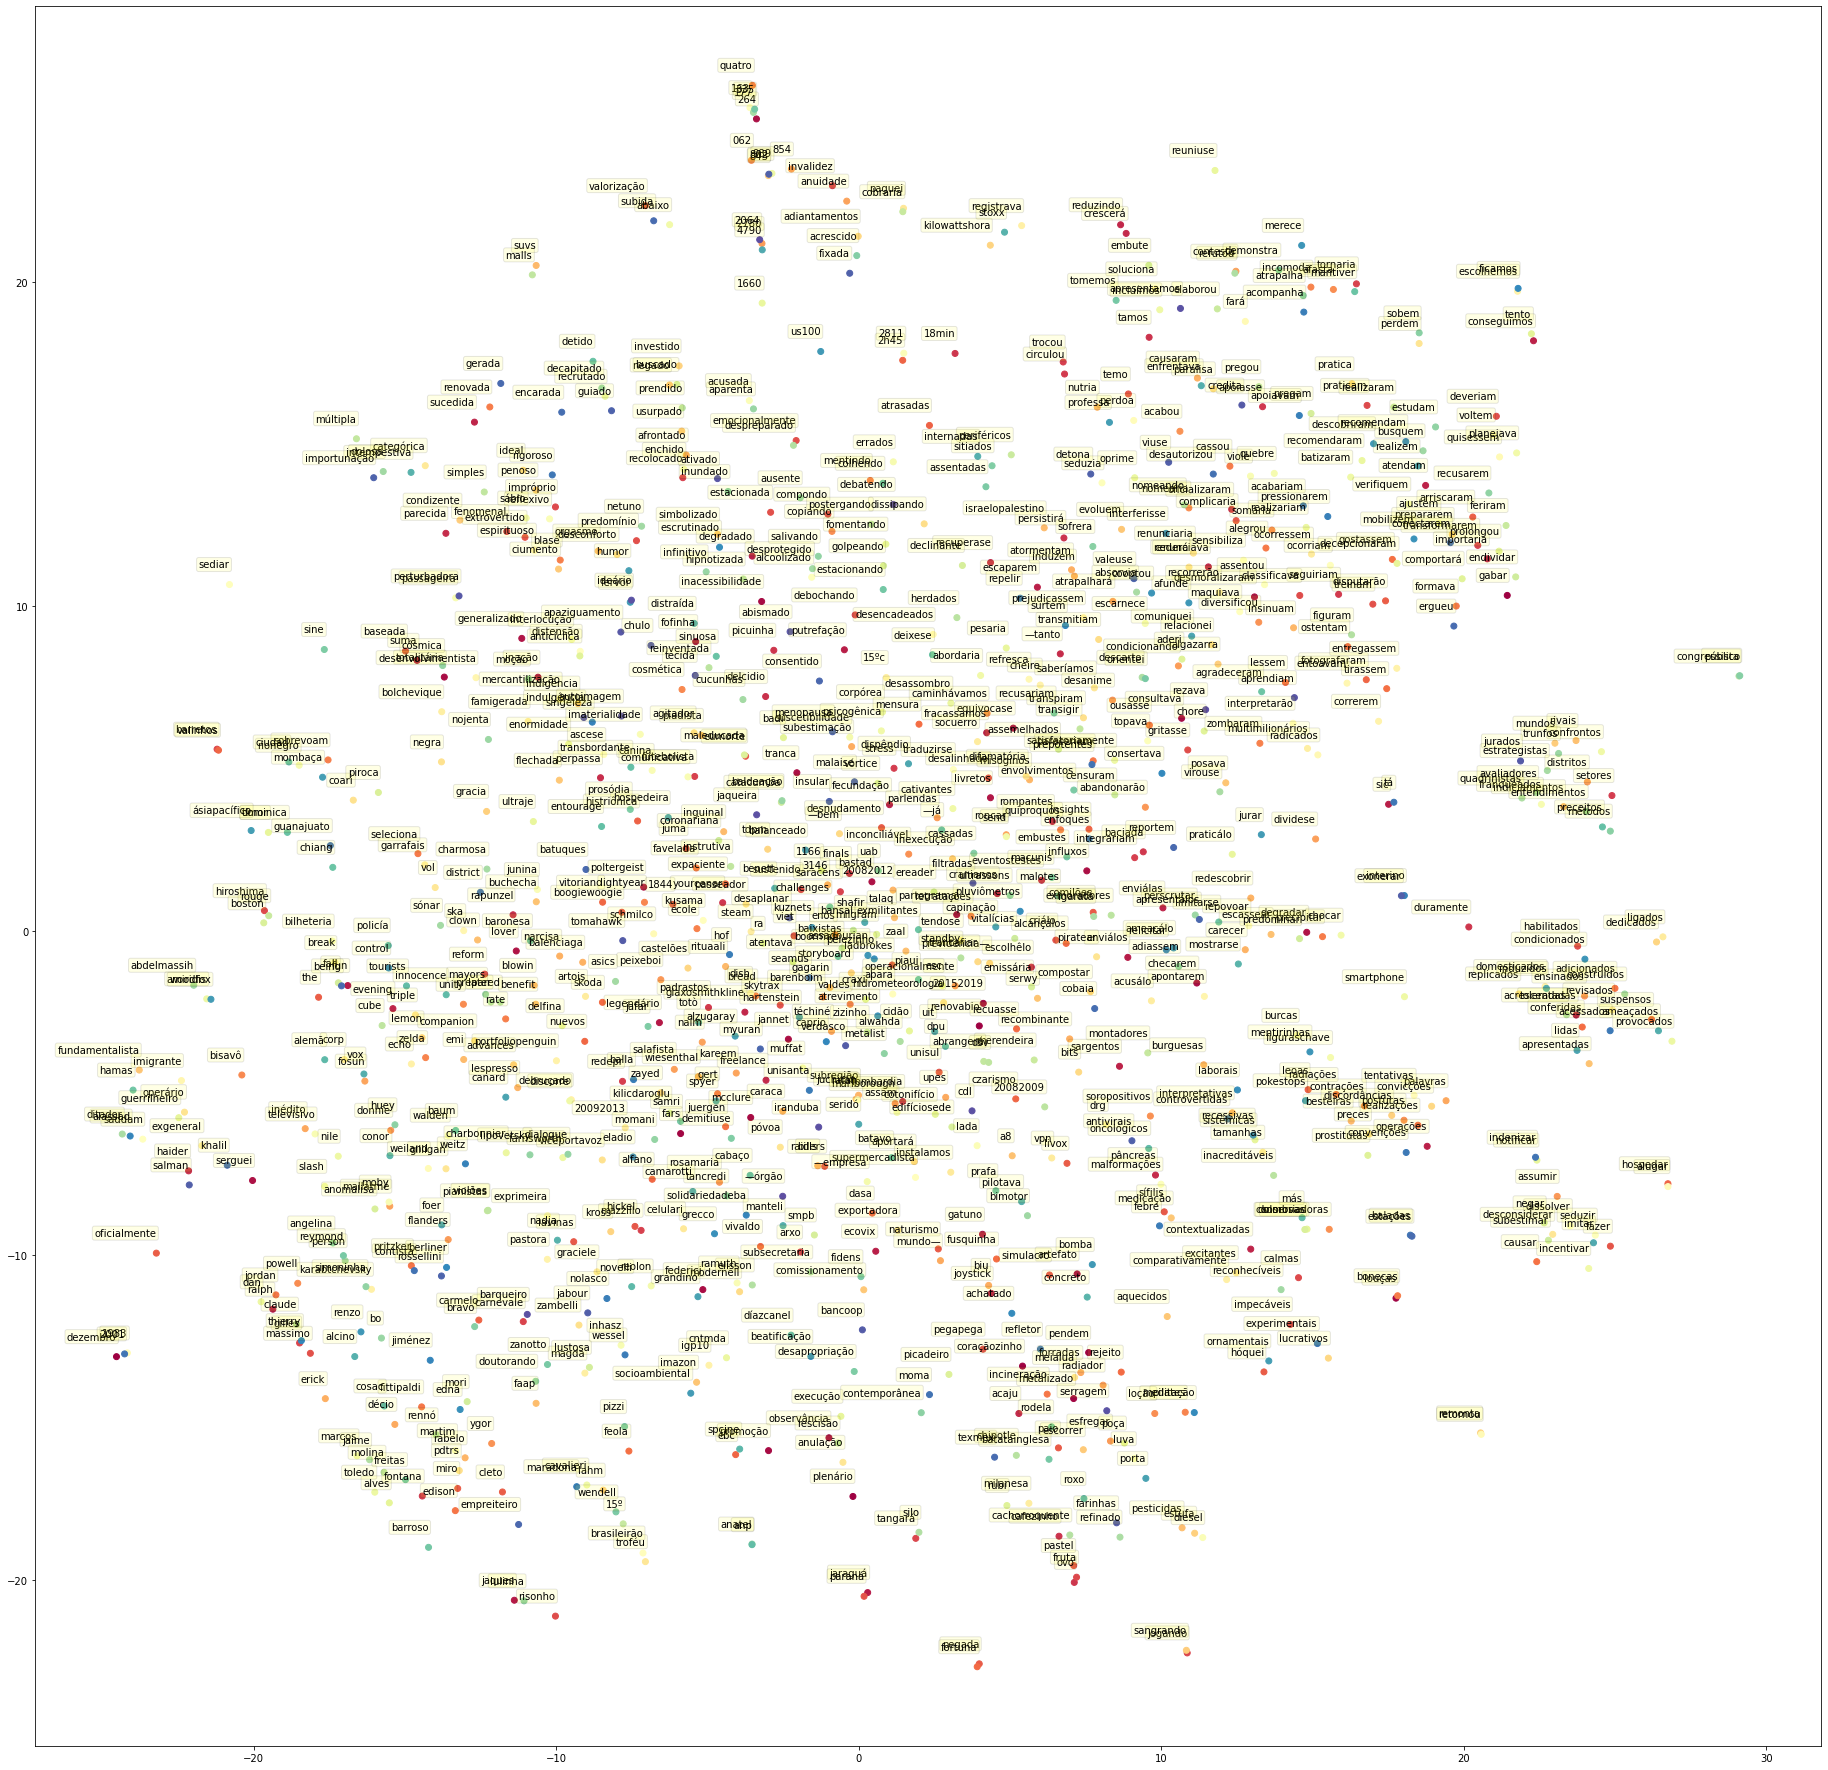

In [11]:
# Gráficos do t-SNE

plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

In [12]:
# First let's visualize the distribution of categories in the dataset
categories, ccount = np.unique(df.category, return_counts=True) 

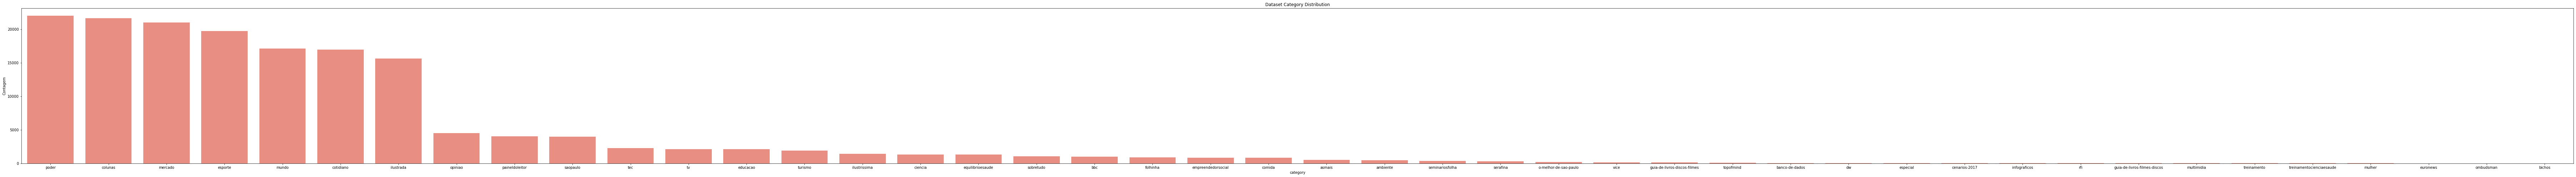

In [13]:
# Contagem das notícias por categoria no dataset completo

Novo_df = df

Novo_df["Contagem"] = 1

Novo_df = Novo_df.groupby('category').agg({'Contagem': 'sum'}).reset_index()
Novo_df = Novo_df.sort_values('Contagem', ascending = [False])

plt.figure(figsize=(128, 8))
plt.title("Dataset Category Distribution")
Plot1 = sns.barplot(x = "category", y = "Contagem", data = Novo_df, color="salmon")

In [14]:
# Crie um iterador que formata os dados do conjunto de dados para o LSTM

# As sequências serão preenchidas ou truncadas para este comprimento
MAX_SEQUENCE_LENGTH = 200

# Amostras de categorias com menos do que este número de amostras serão ignoradas
DROP_THRESHOLD = 10000

class SequenceIterator:
    def __init__(self, dataset, drop_threshold, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset.category, return_counts=True)
        
        self.seq_length = seq_length
        
        # Samples of categories with less than this number of samples will be ignored
        self.drop_categos = []
        for cat, count in zip(self.categories, self.ccount):
            if count < drop_threshold:
                self.drop_categos.append(cat)
        
        # Categorias restantes
        self.categories = np.setdiff1d(self.categories, self.drop_categos)
        
    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            if cat in self.drop_categos:
                continue
            
            # Make all characters lower-case
            news = news.lower()
            
            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[:self.seq_length] if w != ''])
                                
            yield (words, cat)

sequences = SequenceIterator(df, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)
sequences.categories



array(['colunas', 'cotidiano', 'esporte', 'ilustrada', 'mercado', 'mundo',
       'poder'], dtype=object)

In [15]:
# Usado para gerar os rótulos no conjunto

cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])

In [16]:
# Preenchimento com 0

set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

print(set_x.shape)
print(set_y.shape)

(134055, 200)
(134055,)


In [17]:
VALID_PER = 0.25 # % do total que será utilizado para validação

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

Train Shapes - X: (100542, 200) - Y: (100542,)
Val Shapes - X: (33513, 200) - Y: (33513,)


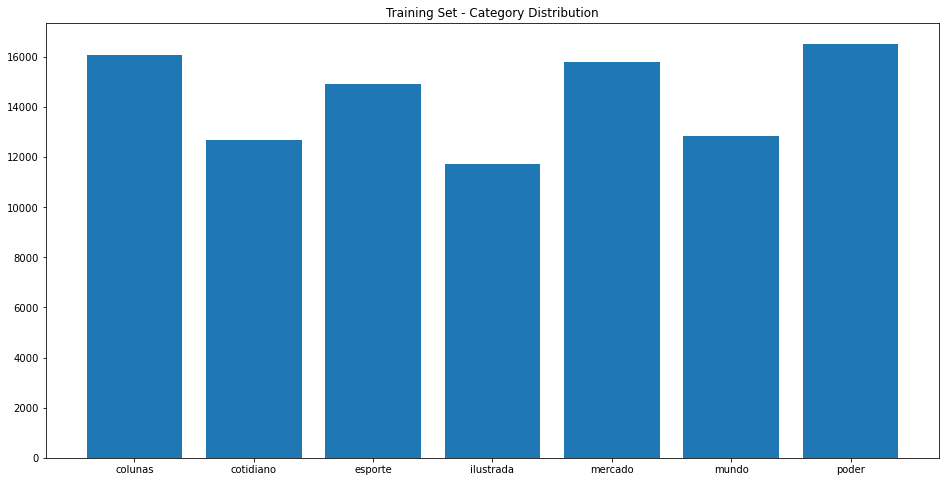

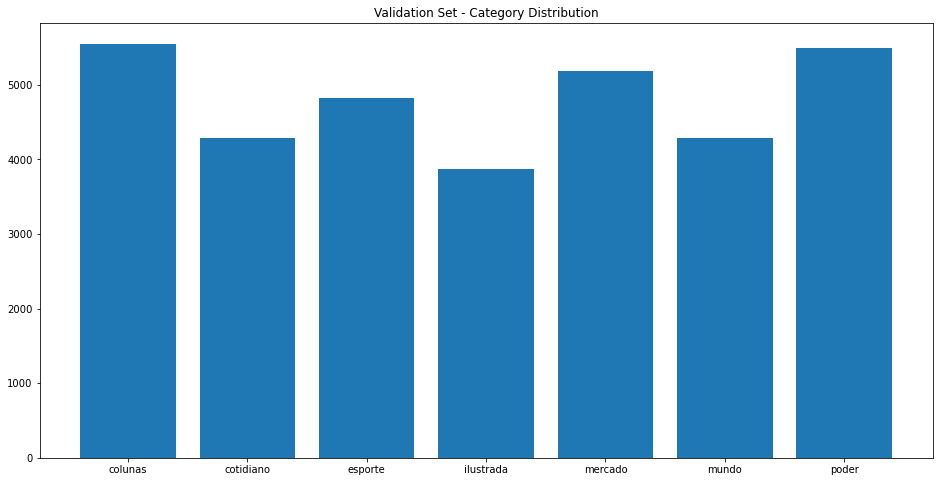

In [18]:
# Gráfico com o grupo de testes

categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(16, 8))
plt.title("Training Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

# Gráfico com o grupo de validação

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(16, 8))
plt.title("Validation Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)

In [19]:
# Ajuste do modelo

model = Sequential()

model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(100)))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=10, batch_size=64,
                    validation_data=(val_x, val_y), verbose=1)

Epoch 1/10
1571/1571 [==============================] - 1131s 710ms/step - loss: 0.7169 - accuracy: 0.7524 - val_loss: 0.4260 - val_accuracy: 0.8492
Epoch 2/10
1571/1571 [==============================] - 1101s 701ms/step - loss: 0.3818 - accuracy: 0.8668 - val_loss: 0.4010 - val_accuracy: 0.8586
Epoch 3/10
1571/1571 [==============================] - 1116s 710ms/step - loss: 0.3146 - accuracy: 0.8893 - val_loss: 0.3814 - val_accuracy: 0.8655
Epoch 4/10
1571/1571 [==============================] - 1067s 679ms/step - loss: 0.2663 - accuracy: 0.9050 - val_loss: 0.3628 - val_accuracy: 0.8717
Epoch 5/10
1571/1571 [==============================] - 896s 571ms/step - loss: 0.2222 - accuracy: 0.9218 - val_loss: 0.3771 - val_accuracy: 0.8717
Epoch 6/10
1571/1571 [==============================] - 921s 586ms/step - loss: 0.1814 - accuracy: 0.9366 - val_loss: 0.3980 - val_accuracy: 0.8718
Epoch 7/10
1571/1571 [==============================] - 900s 573ms/step - loss: 0.1482 - accuracy: 0.9479 - 

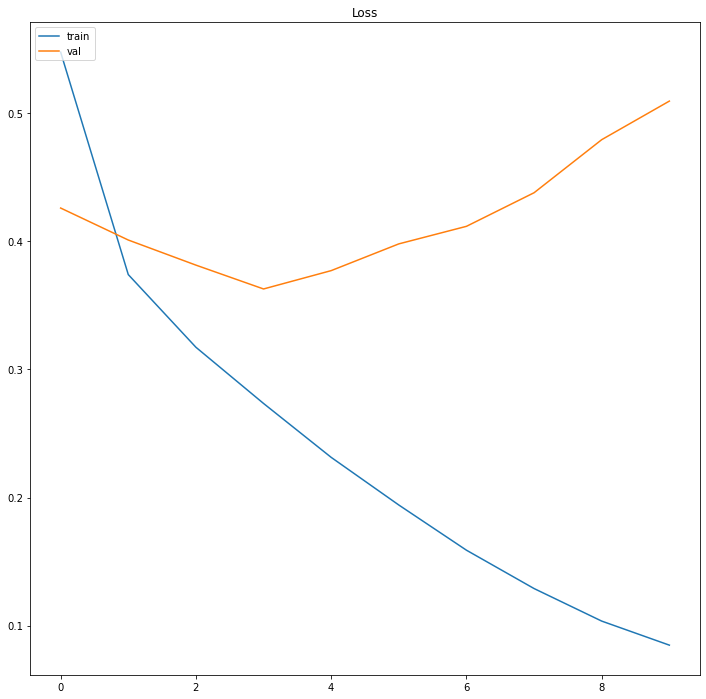

KeyError: 'acc'

<Figure size 864x864 with 0 Axes>

In [20]:
# Gráfico de acurácia

plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 